# <font color='blue'>Forecasting stock price using artificial neural network and genetic algorithm</font>

## Capstone Project
Data Source: https://finance.yahoo.com/

In [1]:
# import the required libraries

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Index symbols
#Dow Jones Industrial Average - DJI
#S&P 500 - GSPC
#NASDAQ Composite - IXIC

sdate = "2015-01-01"
edate = "2023-12-31"
symbols = ['^DJI','^GSPC','^IXIC']

# Download data from yahoo finance
dfs = []
for symbol in symbols:
    yfdata = yf.download(symbol, start=sdate, end=edate)
    yfdata['Index'] = symbol
    dfs.append(yfdata)

# Concatenate the individual DataFrames into one
idx_data = pd.concat(dfs)
idx_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Index
Date,,,,,,,
2015-01-02,17823.070312,17951.779297,17731.300781,17832.990234,17832.990234,76270000,^DJI
2015-01-05,17821.300781,17821.300781,17475.929688,17501.650391,17501.650391,116160000,^DJI
2015-01-06,17504.179688,17581.050781,17262.369141,17371.640625,17371.640625,101870000,^DJI
2015-01-07,17374.779297,17597.080078,17374.779297,17584.519531,17584.519531,91030000,^DJI
2015-01-08,17591.970703,17916.039062,17591.970703,17907.869141,17907.869141,114890000,^DJI


In [3]:
#clean the Index name in the Index column
idx_data['Index'] = idx_data['Index'].apply(lambda x: re.sub("\^","",x) )
idx_data['Index'].value_counts()

Index
DJI     2264
GSPC    2264
IXIC    2264
Name: count, dtype: int64

### Check for data completeness i.e. zero datapoints or NA datapoints

In [4]:
(idx_data == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Index        0
dtype: int64

Check for NA or Null datapoints

In [5]:
idx_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Index        0
dtype: int64

In [6]:
# size
row = idx_data.shape[0]
print(row)

6792


Plot the Closing price timeseries for each index

In [7]:
symbols1 = [re.sub("\^","", x ) for x in symbols]
symbols1

['DJI', 'GSPC', 'IXIC']

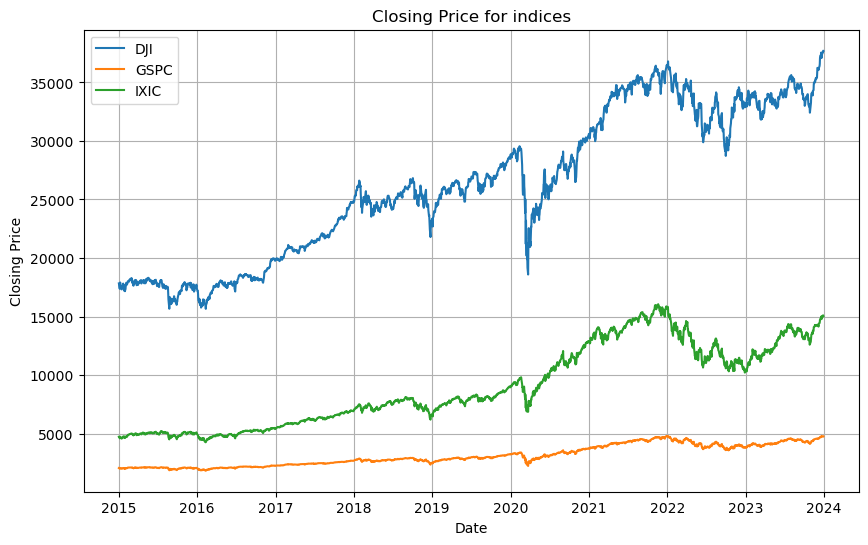

In [8]:
# Plot the closing price for each index
plt.figure(figsize=(10, 6))
for symbol in symbols1:
    ticker_data = idx_data[idx_data['Index'] == symbol]
    plt.plot(ticker_data.index, ticker_data['Close'], label=symbol)

plt.title('Closing Price for indices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

### Derive technical indicators



    1	Open	          The open price
    2	Low               The lowest price
    3	High	          The highest price
    4	Close             The closing price
    5	Volume            Number of shares traded
    6	SMA-5             5-days simple moving average
    7	SMA-10	        10-days simple moving average
    8	EMA-5             5-days exponential moving average
    9	MP	            Mean Price
    10   TP	            Typical Price
    11   RSI               Relative Strength Index
    12   Williams %R       Williams Percent Range
    13   Upper Band	    Upper Bolinger Band
    14   Lower Band	    Lower Bolinger Band
    15   ROC	           Rate of Change
    16   ATR	           Average True Range	
    17   ADL	           Accumulation distribution Line
    18   MFI	           Money Flow Index
    19   CCI	           Commodity Channel Index

In [9]:
# Compute technical indicators

# calculate simple moving avergae
def SMA(data, window):
    cname = 'SMA_' + str(window)
    data[cname] = data.groupby('Index')['Close'].rolling(window).mean().reset_index(0, drop=True)
    return data

def EMA(data, window):
    def cal_EMA(closepx, window):
        k = 2 / (window+1)
        nrow = closepx.size
        ema = [np.nan] * nrow
        ema[window - 1] = np.mean(closepx[:window])
        for i in range(window, nrow):
            ema[i] = (closepx.iloc[i] * k) + (ema[i - 1] * (1 - k))
        return ema
    cname = 'EMA_' + str(window)
    data[cname] = data.groupby('Index')['Close'].transform(lambda x: cal_EMA(x,window))
    return data

# calculate the Bollinger Bands 
def Bollinger_bands(data, window):
    data["MA"] = data.groupby('Index')['Close'].rolling(window).mean().reset_index(0, drop=True)
    data["SD"] = data.groupby('Index')['Close'].rolling(window).std().reset_index(0, drop=True)
    data['UpperBand'] = data["MA"] + (2 * data["SD"] ) 
    data['LowerBand'] = data["MA"] - (2 * data["SD"] )
    data = data.drop(['MA', 'SD'], axis=1)
    return data

# calculate rate of change
def ROC(data, window):
    def cal_ROC(closepx, window):
        roc = closepx.pct_change(periods=window)
        return roc
    data['ROC'] = data.groupby('Index')['Close'].transform(lambda x: cal_ROC(x,window))
    return data

# calculate RSI values
def RSI(data, window):
    def cal_RSI(closepx,window):
        diff = closepx.diff(1)
        up_direction = diff.where(diff > 0, 0.0)
        down_direction = -diff.where(diff < 0, 0.0)
        min_periods = window
        emaup = up_direction.ewm(
            alpha=1 / window, min_periods=min_periods, adjust=False
        ).mean()
        emadn = down_direction.ewm(
            alpha=1 / window, min_periods=min_periods, adjust=False
        ).mean()
        relative_strength = emaup / emadn
        rsi = pd.Series(
            np.where(emadn == 0, 100, 100 - (100 / (1 + relative_strength))),
            index=closepx.index,
        )
        return rsi
    data['RSI'] = data.groupby('Index')['Close'].transform(lambda x: cal_RSI(x,window))
    return data

#Below indicators used more than one parameter in addition to Close. They also use High and Low prices.
# Volume based indicator also use Volume as their input

def williamsR(df,window):
    high = df["High"]
    low = df["Low"]
    close = df["Close"]
    highest_high = high.rolling( window).max()  # highest high over the window
    lowest_low =  low.rolling(window  ).min()  # lowest low over the window
    wr = -100 * (highest_high - close) / (highest_high - lowest_low)
    return wr

def ATR(df, window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    pclose = df['Close'].shift(1)
    tr1 =    high - low
    tr2 = (high - pclose).abs()
    tr3 = (low - pclose).abs()
    true_range = pd.DataFrame(data={"tr1": tr1, "tr2": tr2, "tr3": tr3}).max(axis=1)
    atr = np.full(len(close), np.nan)
    atr[window - 1] = true_range[0 : window].mean()
    for i in range(window, len(atr)):
        atr[i] = (atr[i - 1] * (window - 1) + true_range.iloc[i]) / float( window )
    #atr = pd.Series(data=atr)
    return atr

def ADI(df):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    volume = df['Volume']
    clv = ((close - low) - (high - close)) / ( high - low)
    clv = clv.fillna(0.0)  # float division by zero
    adi = clv * volume
    adi = adi.cumsum()
    return adi

def MFI(df,window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    volume = df['Volume']
    TP = (high + low + close) / 3.0
    up_down = np.where( TP > TP.shift(1), 1, np.where(TP < TP.shift(1), -1, 0),)
    mfr = TP * volume * up_down

    n_positive_mf = mfr.rolling(window).apply(lambda x: np.sum(np.where(x >= 0.0, x, 0.0)), raw=True )
    n_negative_mf = abs(mfr.rolling(window).apply(lambda x: np.sum(np.where(x < 0.0, x, 0.0)), raw=True))
    
    mfi = n_positive_mf / n_negative_mf
    mfi = 100 - (100 / (1 + mfi))
    
    return mfi

def CCI(df,window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    TP = (high + low + close) / 3.0
    constant = 0.015
    def _mad(x):
        return np.mean(np.abs(x - np.mean(x)))
    
    cci = ( TP - TP.rolling(window).mean() ) / (
            constant  * TP.rolling(window).apply( _mad, True  )
    )
    return cci

In [10]:
#calculate technical indicator

idx_data["MP"] =  (idx_data["High"] + idx_data["Low"]  ) / 2.0
idx_data["TP"] = (idx_data["High"] + idx_data["Low"] + idx_data["Close"]  ) / 3.0
idx_data = SMA(idx_data,5)
idx_data = SMA(idx_data,10)
idx_data = EMA(idx_data,5)
idx_data = RSI(idx_data,20)
idx_data = Bollinger_bands(idx_data,20)
idx_data = ROC(idx_data,1)

In [11]:
# Now, separate each index data from the combined data 
dow    = idx_data[idx_data["Index"] == "DJI"]
sp5    = idx_data[idx_data["Index"] == "GSPC"]
nasdaq = idx_data[idx_data["Index"] == "IXIC"]

with pd.option_context('mode.chained_assignment', None):
    
    #calculate technical indicators where more than one price parameter [Close] is used.
    dow["WR"] = williamsR(dow,14)
    dow["ATR"] = ATR(dow,14)
    dow["ADI"] = ADI(dow)
    dow["MFI"] = MFI(dow,14)
    dow["CCI"] = CCI(dow,20)

    sp5["WR"] = williamsR(sp5,14)
    sp5["ATR"] = ATR(sp5,14)
    sp5["ADI"] = ADI(sp5)
    sp5["MFI"] = MFI(sp5,14)
    sp5["CCI"] = CCI(sp5,20)

    nasdaq["WR"] = williamsR(nasdaq,14)
    nasdaq["ATR"] = ATR(nasdaq,14)
    nasdaq["ADI"] = ADI(nasdaq)
    nasdaq["MFI"] = MFI(nasdaq,14)
    nasdaq["CCI"] = CCI(nasdaq,20)
    
    # Target price is next day closing price
    dow['Targetprice']    = dow['Close'].shift(-1)
    sp5['Targetprice']    = sp5['Close'].shift(-1)
    nasdaq['Targetprice'] = nasdaq['Close'].shift(-1)

In [12]:
dow.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Index', 'MP',
       'TP', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'UpperBand', 'LowerBand',
       'ROC', 'WR', 'ATR', 'ADI', 'MFI', 'CCI', 'Targetprice'],
      dtype='object')

In [13]:
# Remove NAN or NA values from the dataframe
with pd.option_context('mode.chained_assignment', None):
    dow.dropna(inplace=True)
    sp5.dropna(inplace=True)
    nasdaq.dropna(inplace=True)

In [14]:
dow.shape

(2244, 22)

### Artifical Neural Network (ANN) Training

We will train the ANN model on the Dow index. We have 19 features in the input layer. Output layer consits of 1 Node i.e. predicted closing price. Down index had total 2244 rows. Out of this 80% data is used for training and 20% data is used for out-of-sample testing. Input features are scaled using MinMaxScaler to bring all the features on a same scale. This results in a dataset with values ranging between 0 and 1

In [15]:
X = dow.drop(['Adj Close','Index','Targetprice'], axis=1)
y = dow['Targetprice']

# Min-Max scaling on input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1795, 19)
(449, 19)
(1795,)
(449,)


In [16]:
# The neural network model
model = Sequential([
    Dense(20, activation='relu', input_shape=(X_train.shape[1],)),  # One hidden layer with 32 neurons
    Dense(1)  # Output layer with one neuron (for price prediction)
])

C:\Users\hjeen\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 729140608.0000
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 730657728.0000
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 729938368.0000
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 733913280.0000
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 734848128.0000
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 739259072.0000
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 739529280.0000
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 743163136.0000
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 731352576.0000
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 728452992.0000
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 730915584.0000
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 721139200.0000
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 716703296.0000
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

In [18]:
predictions = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [19]:
predictions.shape

(449, 1)

In [20]:
y_test.head()

Date
2021-09-13    34577.570312
2023-12-21    37385.968750
2021-03-29    33066.960938
2016-01-13    16379.049805
2017-10-19    23328.630859
Name: Targetprice, dtype: float64